In [935]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf
import os
from scipy.optimize import minimize
from scipy.stats import norm
import multiprocess as mp
from functools import partial
import seaborn as sns
import scipy.stats as ss

In [1481]:
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [165]:
def parallelize(data, func, num_of_processes=mp.cpu_count()):
    data_split = np.array_split(data, num_of_processes)
    pool = mp.Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

In [196]:
# Grid Range
log_tau_range = (np.log(30/365), np.log(1))
log_m_range = (np.log(0.6), np.log(1.4))

# Grid Number of Points
tau_n_points = 20
m_n_points = 20

# Grid Vector Alternative
log_tau_grid_vec = np.linspace(log_tau_range[0], log_tau_range[1], tau_n_points)
log_m_grid_vec = np.linspace(log_m_range[0], log_m_range[1], m_n_points)

log_tau_vec = np.tile(log_tau_grid_vec, 20)
log_m_vec = log_m_grid_vec.repeat(20)

# VAE

In [762]:
arr_vae = os.listdir('../models/VAE/results')

In [763]:
file_name_vae = np.delete(np.array(arr_vae), np.where(np.isin(np.array(arr_vae), ['.DS_Store', '.ipynb_checkpoints'])))
dates_vae = pd.to_datetime(np.char.replace(file_name_vae, '.csv', ''))

In [764]:
df_vae = pd.DataFrame(file_name_vae, index=dates_vae, columns=['file_name'])

In [765]:
def process_vae(s):
    s = s.copy()
    df_vol = pd.read_csv(f'../models/VAE/results/{s["file_name"]}')
    for n in [10, 100, 350, 400]:
        s[f'rmse_{n}'] = np.sqrt(np.mean(np.square(df_vol[f'{n}_sigma_full'] - df_vol['sigma'])))
        s[f'min_{n}'] = np.min(np.abs(df_vol[f'{n}_sigma_full'] - df_vol['sigma']))
        s[f'mean_{n}'] = np.mean(np.abs(df_vol[f'{n}_sigma_full'] - df_vol['sigma']))
        s[f'median_{n}'] = np.median(np.abs(df_vol[f'{n}_sigma_full'] - df_vol['sigma']))
        s[f'max_{n}'] = np.max(np.abs(df_vol[f'{n}_sigma_full'] - df_vol['sigma']))
        
    return s

In [766]:
df_finished_vae = df_vae.apply(process_vae, axis=1)

In [1772]:
df_finished_vae = df_finished_vae.sort_index()

In [1773]:
df_finished_vae.to_pickle('vae.pkl')

In [767]:
df_interp_vae = df_finished_vae.resample('1w').mean().fillna(method='bfill')

/var/folders/r0/l1q6kw3908j551blj1nklmn40000gn/T/ipykernel_37700/2657676112.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_interp_vae = df_finished_vae.resample('1w').mean().fillna(method='bfill')


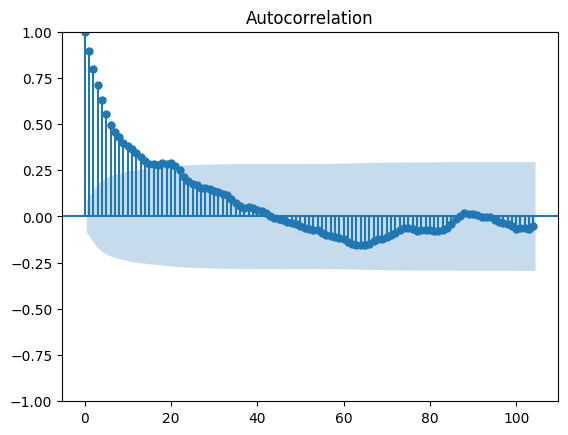

In [768]:
plot_acf(df_interp_vae['mean_400'], lags=52*2)
plt.show()

# Heston

## Imply

In [1494]:
arr_h = os.listdir('../models/Heston/results_3')

In [1495]:
file_name_h = np.delete(np.array(arr_h), np.where(np.isin(np.array(arr_h), ['.DS_Store', '.ipynb_checkpoints'])))
dates_h = pd.to_datetime(np.char.replace(file_name_h, '.csv', ''))

In [1496]:
df_h = pd.DataFrame(file_name_h, index=dates_h, columns=['file_name'])

In [1497]:
s = df_h.iloc[0].copy()

In [1498]:
df_vol = pd.read_csv(f'../models/Heston/results_3/{s["file_name"]}')

In [1499]:
def black_scholes_call(sigma, S_t, K, tau, r, q):
    d_1 = (np.log(S_t / K) + (r - q + (sigma**2 / 2)) * tau) / (sigma * np.sqrt(tau))
    d_2 = d_1 - (sigma * np.sqrt(tau))
    return norm.cdf(d_1) * S_t * np.exp(-q * tau) - norm.cdf(d_2) * K * np.exp(-r * tau)

In [1500]:
def implied_volatilitiy_call_of(sigma, S_t, K, tau, r, q, C):
    bsc = black_scholes_call(sigma[0], S_t, K, tau, r, q)
    of = C - bsc
    return of**2

In [1501]:
def implied_volatility(option_data_s):
    
    results = option_data_s.copy()
    
    xrtol = 1e-4
    obj_max = 1e-04
    
    S_t = option_data_s['S_t']
    K = option_data_s['K']
    tau = option_data_s['tau']
    r = option_data_s['r']
    q = option_data_s['q']
    
    for n in [10, 100, 350, 400]:
        price = option_data_s[f'{n}_heston_price']
        result_vol = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r-q, q, price), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        impl_vol = result_vol.x[0] if result_vol.fun < obj_max else np.nan
        results[f'{n}_heston_impl_vol'] = impl_vol
        
    result_vol = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r-q, q, option_data_s[f'call_price']), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
    impl_vol = result_vol.x[0] if result_vol.fun < obj_max else np.nan
    results[f'reimply_sigma'] = impl_vol
    
    return results
    

In [1502]:
def full_process(s):
    df_vol = pd.read_csv(f'../models/Heston/results_3/{s["file_name"]}')
    result = parallelize_on_rows(df_vol, implied_volatility).apply(pd.Series)
    result.to_csv(f'../models/Heston/results_3_vol/{s["file_name"]}', index=False)
    return s

In [1503]:
import tqdm

In [1504]:
for index, row in tqdm.tqdm(df_h.iterrows(), total=len(df_h)):
    full_process(row)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 688/688 [10:01<00:00,  1.14it/s]


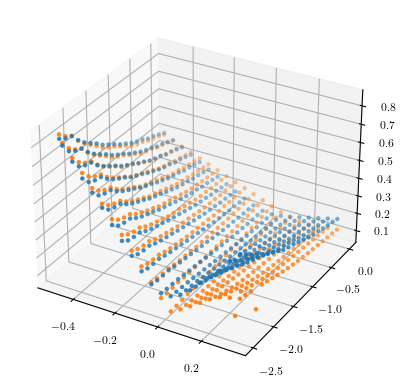

In [1508]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.log(test['m']), np.log(test['tau']), test['100_heston_impl_vol'], s=5)
ax.scatter(np.log(test['m']), np.log(test['tau']), test['reimply_sigma'], s=5)
plt.show()

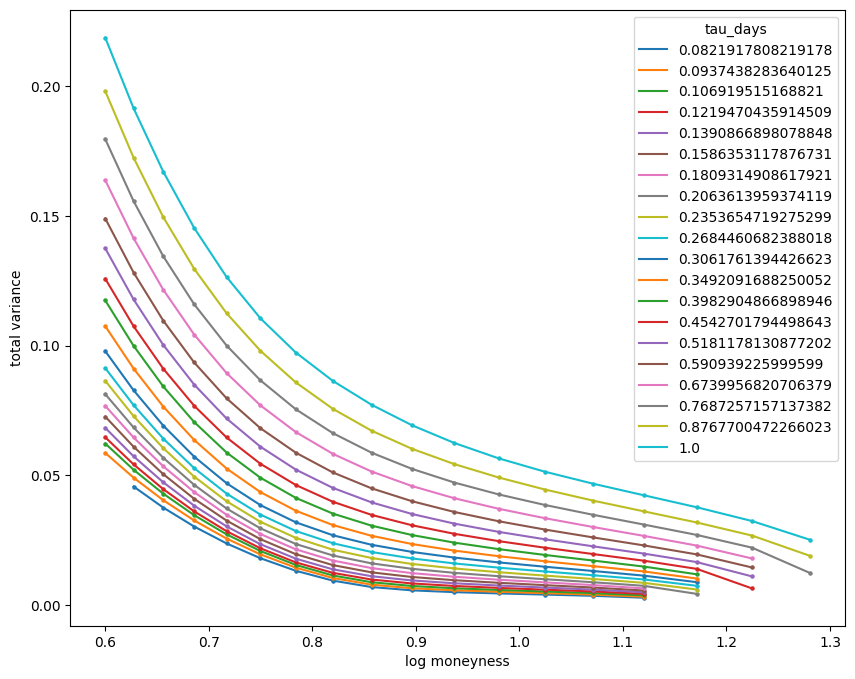

In [599]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for name, group in test.groupby('tau'):
    ax.plot(group['m'], np.square(group['400_heston_impl_vol'])*group['tau'], zorder=1, label=name)
    ax.scatter(group['m'], np.square(group['400_heston_impl_vol'])*group['tau'], zorder=1, s=5)
    
ax.legend(title='tau_days', loc='upper right')
ax.set_xlabel('log moneyness')
ax.set_ylabel('total variance')

plt.show()

# Full

## Aggregation

In [1509]:
arr_h_vol = os.listdir('../models/Heston/results_3_vol')

In [1510]:
file_name_h_vol = np.delete(np.array(arr_h_vol), np.where(np.isin(np.array(arr_h_vol), ['.DS_Store', '.ipynb_checkpoints'])))
dates_h_vol = pd.to_datetime(np.char.replace(file_name_h_vol, '.csv', ''))

In [1511]:
df_h_vol = pd.DataFrame(file_name_h_vol, index=dates_h_vol, columns=['file_name'])

In [1512]:
def process_h(s):
    s = s.copy()
    df_vol = pd.read_csv(f'../models/Heston/results_3_vol/{s["file_name"]}')
    for n in [10, 100, 350, 400]:
        diff = df_vol[f'{n}_heston_impl_vol'] - df_vol['reimply_sigma']
        diff = diff[~diff.isna()]
        s[f'rmse_{n}'] = np.sqrt(np.mean(np.square(diff)))
        s[f'min_{n}'] = np.min(np.abs(diff))
        s[f'mean_{n}'] = np.mean(np.abs(diff))
        s[f'median_{n}'] = np.median(np.abs(diff))
        s[f'max_{n}'] = np.max(np.abs(diff))
        
    return s

In [1769]:
df_finished_h = df_h_vol.apply(process_h, axis=1)
df_finished_h = df_finished_h.sort_index()

In [1770]:
df_finished_h.to_pickle('heston.pkl')

# Full DS

In [1515]:
dfs = []
for fn in file_name_h_vol:
    dfs.append(pd.read_csv(f'../models/Heston/results_3_vol/{fn}'))
    
df_h_full = pd.concat(dfs, axis=0)

In [1516]:
df_h_full.to_pickle('heston_full.pkl')

In [1078]:
dfs = []
for fn in file_name_vae:
    dfs.append(pd.read_csv(f'../models/VAE/results/{fn}'))
    
df_vae_full = pd.concat(dfs, axis=0)

## Figures

In [1482]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 8})# TeX rendering

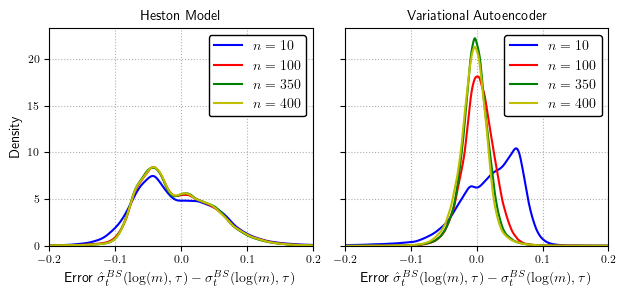

In [2839]:
fig, axs = plt.subplots(1, 2, figsize=(6.3, 3), sharex=True, sharey=True)

sns.kdeplot(df_h_full['10_heston_impl_vol'] - df_h_full['reimply_sigma'], gridsize=500, ax=axs[0], label=r'$n=10$', c='b')
sns.kdeplot(df_h_full['100_heston_impl_vol'] - df_h_full['reimply_sigma'], gridsize=500, ax=axs[0], label=r'$n=100$', c='r')
sns.kdeplot(df_h_full['350_heston_impl_vol'] - df_h_full['reimply_sigma'], gridsize=500, ax=axs[0], label=r'$n=350$', c='g')
sns.kdeplot(df_h_full['400_heston_impl_vol'] - df_h_full['reimply_sigma'], gridsize=500, ax=axs[0], label=r'$n=400$', c='y')

sns.kdeplot(df_vae_full['10_sigma_full'] - df_vae_full['sigma'], gridsize=500, ax=axs[1], label=r'$n=10$', c='b')
sns.kdeplot(df_vae_full['100_sigma_full'] - df_vae_full['sigma'], gridsize=500, ax=axs[1], label=r'$n=100$', c='r')
sns.kdeplot(df_vae_full['350_sigma_full'] - df_vae_full['sigma'], gridsize=500, ax=axs[1], label=r'$n=350$', c='g')
sns.kdeplot(df_vae_full['400_sigma_full'] - df_vae_full['sigma'], gridsize=500, ax=axs[1], label=r'$n=400$', c='y')

axs[1].set_xlim(-0.2,0.2)

leg = axs[0].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

leg = axs[1].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

axs[0].set_title('Heston Model', fontsize=10)
axs[1].set_title('Variational Autoencoder', fontsize=10)

axs[0].set_ylabel(r'Density', fontsize=10)
axs[1].set_ylabel(r'Density', fontsize=10)

axs[0].set_xlabel(r'Error $\hat{\sigma}^{BS}_t(\log(m), \tau) - \sigma^{BS}_t(\log(m), \tau)$', fontsize=10)
axs[1].set_xlabel(r'Error $\hat{\sigma}^{BS}_t(\log(m), \tau) - \sigma^{BS}_t(\log(m), \tau)$', fontsize=10)

axs[0].grid(linestyle='dotted')
axs[1].grid(linestyle='dotted')
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

fig.tight_layout()

fig.savefig('figures/error_kde.pdf')
plt.show()

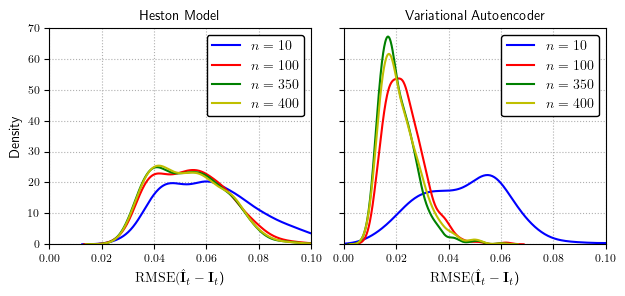

In [2840]:
fig, axs = plt.subplots(1, 2, figsize=(6.3, 3), sharex=True, sharey=True)

sns.kdeplot(df_finished_h['rmse_10'], gridsize=500, ax=axs[0], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_h['rmse_100'], gridsize=500, ax=axs[0], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_h['rmse_350'], gridsize=500, ax=axs[0], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_h['rmse_400'], gridsize=500, ax=axs[0], label=r'$n=400$', c='y')

sns.kdeplot(df_finished_vae['rmse_10'], gridsize=500, ax=axs[1], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_vae['rmse_100'], gridsize=500, ax=axs[1], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_vae['rmse_350'], gridsize=500, ax=axs[1], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_vae['rmse_400'], gridsize=500, ax=axs[1], label=r'$n=400$', c='y')

axs[1].set_xlim(0,0.1)
axs[1].set_ylim(0,70)

leg = axs[0].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

leg = axs[1].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

axs[0].set_title('Heston Model', fontsize=10)
axs[1].set_title('Variational Autoencoder', fontsize=10)

axs[0].set_ylabel(r'Density', fontsize=10)
axs[1].set_ylabel(r'Density', fontsize=10)

axs[0].set_xlabel(r'$\mathrm{RMSE}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)
axs[1].set_xlabel(r'$\mathrm{RMSE}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)

axs[0].grid(linestyle='dotted')
axs[1].grid(linestyle='dotted')
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

fig.tight_layout()

fig.savefig('figures/rmse_kde.pdf')
plt.show()

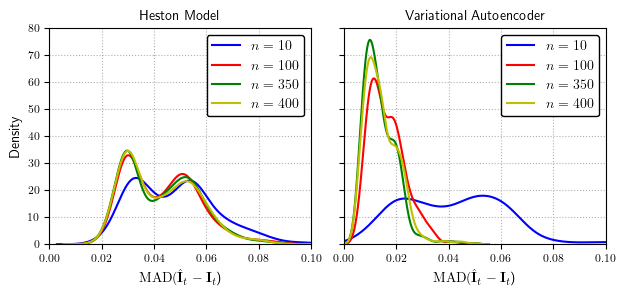

In [2841]:
fig, axs = plt.subplots(1, 2, figsize=(6.3, 3), sharex=True, sharey=True)

sns.kdeplot(df_finished_h['median_10'], gridsize=500, ax=axs[0], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_h['median_100'], gridsize=500, ax=axs[0], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_h['median_350'], gridsize=500, ax=axs[0], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_h['median_400'], gridsize=500, ax=axs[0], label=r'$n=400$', c='y')

sns.kdeplot(df_finished_vae['median_10'], gridsize=500, ax=axs[1], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_vae['median_100'], gridsize=500, ax=axs[1], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_vae['median_350'], gridsize=500, ax=axs[1], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_vae['median_400'], gridsize=500, ax=axs[1], label=r'$n=400$', c='y')

axs[1].set_xlim(0,0.1)
axs[1].set_ylim(0,80)

leg = axs[0].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

leg = axs[1].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

axs[0].set_title('Heston Model', fontsize=10)
axs[1].set_title('Variational Autoencoder', fontsize=10)

axs[0].set_ylabel(r'Density', fontsize=10)
axs[1].set_ylabel(r'Density', fontsize=10)

axs[0].set_xlabel(r'$\mathrm{MAD}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)
axs[1].set_xlabel(r'$\mathrm{MAD}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)

axs[0].grid(linestyle='dotted')
axs[1].grid(linestyle='dotted')
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

fig.tight_layout()

fig.savefig('figures/mad_kde.pdf')
plt.show()

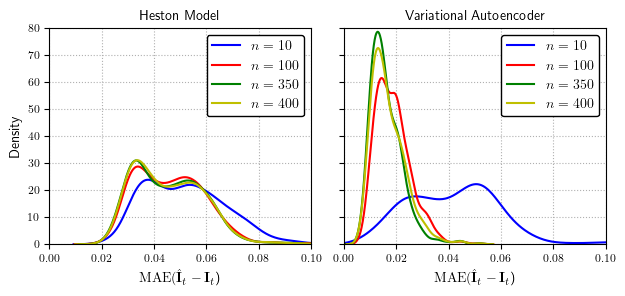

In [2842]:
fig, axs = plt.subplots(1, 2, figsize=(6.3, 3), sharex=True, sharey=True)

sns.kdeplot(df_finished_h['mean_10'], gridsize=500, ax=axs[0], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_h['mean_100'], gridsize=500, ax=axs[0], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_h['mean_350'], gridsize=500, ax=axs[0], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_h['mean_400'], gridsize=500, ax=axs[0], label=r'$n=400$', c='y')

sns.kdeplot(df_finished_vae['mean_10'], gridsize=500, ax=axs[1], label=r'$n=10$', c='b')
sns.kdeplot(df_finished_vae['mean_100'], gridsize=500, ax=axs[1], label=r'$n=100$', c='r')
sns.kdeplot(df_finished_vae['mean_350'], gridsize=500, ax=axs[1], label=r'$n=350$', c='g')
sns.kdeplot(df_finished_vae['mean_400'], gridsize=500, ax=axs[1], label=r'$n=400$', c='y')

axs[1].set_xlim(0,0.1)
axs[1].set_ylim(0,80)

leg = axs[0].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

leg = axs[1].legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

axs[0].set_title('Heston Model', fontsize=10)
axs[1].set_title('Variational Autoencoder', fontsize=10)

axs[0].set_ylabel(r'Density', fontsize=10)
axs[1].set_ylabel(r'Density', fontsize=10)

axs[0].set_xlabel(r'$\mathrm{MAE}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)
axs[1].set_xlabel(r'$\mathrm{MAE}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)

axs[0].grid(linestyle='dotted')
axs[1].grid(linestyle='dotted')
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

fig.tight_layout()

fig.savefig('figures/mae_kde.pdf')
plt.show()

### Autocorrelation

In [1720]:
import matplotlib.patches as mpatches
from matplotlib.collections import PolyCollection
from matplotlib.lines import Line2D

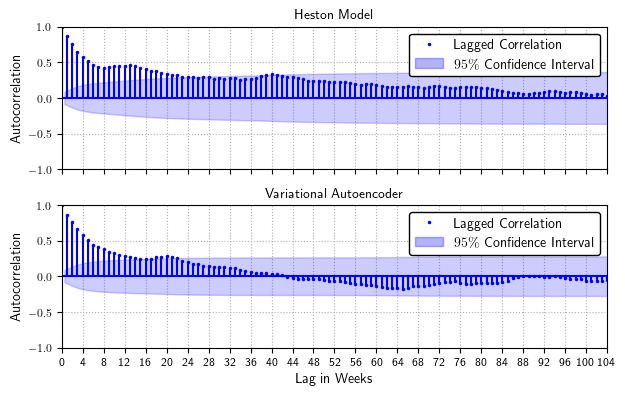

In [2853]:
rmse_400_res_h = df_finished_h['rmse_400'].resample('1w').mean().fillna(method='bfill')
rmse_400_res_vae = df_finished_vae['rmse_400'].resample('1w').mean().fillna(method='bfill')

fig, axs = plt.subplots(2, 1, figsize=(6.3, 4), sharex=True, sharey=True)

plot_acf(rmse_400_res_h, lags=52*2, ax=axs[0], alpha=0.05, vlines_kwargs={"linewidth": 1.5, 'color': 'b'}, c='b')
plot_acf(rmse_400_res_vae, lags=52*2, ax=axs[1], alpha=0.05, vlines_kwargs={"linewidth": 1.5, 'color': 'b'}, c='b')

axs[0].set_xlim(0,52*2)

for line in axs[0].lines:
    line.set_markersize(1.5)
    line.set_linewidth(1.5)
    
for line in axs[1].lines:
    line.set_markersize(1.5)
    line.set_linewidth(1.5)
        
for ax in axs:
    ax.set_title('Autocorrelation Plot', fontsize=12)
    ax.set_xlabel('Lag', fontsize=10)
    ax.set_ylabel('Autocorrelation', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
axs[0].grid(linestyle='dotted')
axs[1].grid(linestyle='dotted')
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

axs[0].set_xticks(np.arange((52/4)*2+1, dtype='int')*4, np.arange((52/4)*2+1, dtype='int')*4)

for item in axs[0].collections:
    if type(item)==PolyCollection:
        item.set_alpha(0.2)
        item.set_color('b')
        
for item in axs[1].collections:
    if type(item)==PolyCollection:
        item.set_alpha(0.2)
        item.set_color('b')

corr_dot = Line2D([0], [0], lw=0, ms=1.5, label='Lagged Correlation', marker='o', c='b')
blue_patch = mpatches.Patch(label=f'$95\%$ Confidence Interval', alpha=0.3, color='b')
axs[0].legend(handles=[corr_dot, blue_patch])

leg = axs[0].legend(handles=[corr_dot, blue_patch], fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

leg = axs[1].legend(handles=[corr_dot, blue_patch], fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

axs[0].set_title('Heston Model')
axs[1].set_title('Variational Autoencoder')

axs[0].set_xlabel(None)
axs[1].set_xlabel('Lag in Weeks')


fig.tight_layout()
plt.savefig('figures/rmse_acf.pdf')
plt.show()

# Bootstrap

In [1778]:
dates = pd.DataFrame(pd.to_datetime(pd.read_csv('../pre_processing_pipeline/data_meta_2.csv')['date']))

In [1779]:
dates = dates.loc[dates['date'] >= '2013-01-01']

In [1780]:
merge_1 = pd.merge(dates, df_finished_h, left_on='date', right_index=True, how='left', suffixes=['', '_heston'])

In [1781]:
merged = pd.merge(merge_1, df_finished_vae, left_on='date', right_index=True, how='left', suffixes=['_heston', '_vae'])

In [1782]:
merged.index = merged['date']

In [2260]:
k = 5
h = 0.00001
n = 101

In [2278]:
def bootstrap(s):
    if s.shape[0] != n:
        return np.nan
    indx = ~s.isna().values
    k_nn = np.where((indx[:int((n-1)/2)] | indx[-int((n-1)/2):]))[0][k]
    w = ssignal.gaussian(n, k*n)
    return ss.gaussian_kde(s[indx], weights=w[indx]).resample(1)

In [2279]:
merged_adj = merged.copy().reset_index(drop=True)
merged_adj_ridx = merged_adj.reindex(pd.RangeIndex(merged_adj.index.start-n//2, merged_adj.index.stop+n//2))

In [2280]:
test = merged_adj_ridx.rolling(n, center=True, min_periods=0).agg(bootstrap).iloc[int((n-1)/2):-int((n-1)/2)]
test.index = merged_adj['date']

/var/folders/r0/l1q6kw3908j551blj1nklmn40000gn/T/ipykernel_37700/2120018551.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'file_name_heston', 'file_name_vae'], dtype='object')
  test = merged_adj_ridx.rolling(n, center=True, min_periods=0).agg(bootstrap).iloc[int((n-1)/2):-int((n-1)/2)]


In [2622]:
final_data = test_b

In [2300]:
merged_dropped = merged.drop(['date', 'file_name_heston', 'file_name_vae'], axis=1).dropna()

In [2301]:
merged_dropped = merged.drop(['date', 'file_name_heston', 'file_name_vae'], axis=1).dropna()
test_b = test.copy()
test_b.loc[merged_dropped.index] = merged_dropped

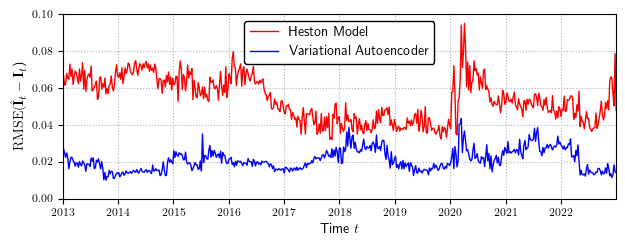

In [2854]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 2.5), sharex=True, sharey=True)

ax.plot(test_b['rmse_400_heston'].resample('1w').mean().fillna(method='bfill'), linewidth=1, label='Heston Model', c='r')
ax.plot(test_b['rmse_400_vae'].resample('1w').mean().fillna(method='bfill'), linewidth=1, label='Variational Autoencoder', c='b')

leg = ax.legend(fontsize=10)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_alpha(None)

ax.set_xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2022-12-31'))
ax.set_ylim(0, 0.1)

ax.grid(linestyle='dotted')
ax.set_axisbelow(True)

ax.set_ylabel(r'$\mathrm{RMSE}(\hat{\mathbf{I}}_t - \mathbf{I}_t$)', fontsize=10)
ax.set_xlabel(r'Time $t$', fontsize=10)
    
fig.tight_layout()
plt.savefig('figures/rmse_historic.pdf', format='pdf')
plt.show()

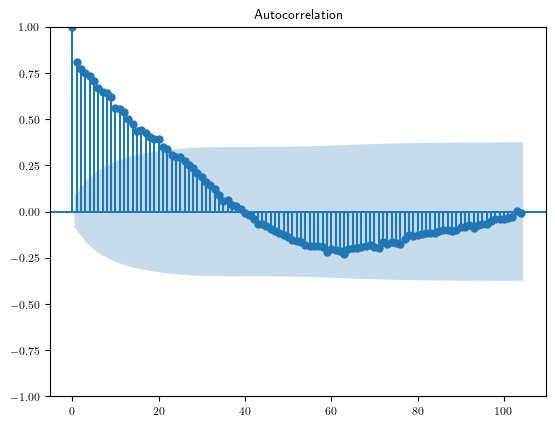

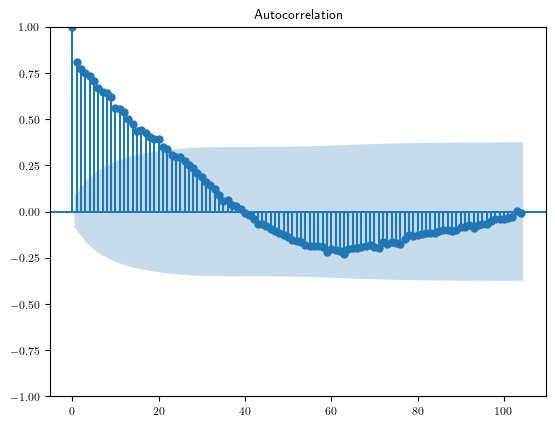

In [2312]:
plot_acf(test_b['rmse_400_vae'].resample('1w').mean(), lags=52*2)

## Bootstrap

In [2579]:
def block_bootstrap(series, block_size, num_samples):
    n = len(series)
    indices = np.arange(n)
    num_blocks = n // block_size
    blocks = [indices[i*block_size:(i+1)*block_size] for i in range(num_blocks)]
    bootstrap_samples = []
    for _ in range(num_samples):
        sample_indices = np.hstack([blocks[i] for i in np.random.choice(num_blocks, num_blocks, replace=True)])
        bootstrap_sample = series[sample_indices]
        bootstrap_samples.append(bootstrap_sample)
    return bootstrap_samples

def wilcoxon_signed_rank_test_with_block_bootstrap(series1, series2, block_size, num_bootstrap_samples):
    bootstrap_series1 = block_bootstrap(series1, block_size, num_bootstrap_samples)
    bootstrap_series2 = block_bootstrap(series2, block_size, num_bootstrap_samples)
    
    p_values = []
    for b_series1, b_series2 in zip(bootstrap_series1, bootstrap_series2):
        _, p_value = wilcoxon(b_series1, b_series2)
        p_values.append(p_value)
    
    avg_p_value = np.mean(p_values)
    return avg_p_value

In [2614]:
block_size = 105
num_bootstrap_samples = 10000

In [2615]:
rmse_10_res_h = df_finished_h['rmse_10'].resample('1w').mean().fillna(method='bfill')
rmse_10_res_vae = df_finished_vae['rmse_10'].resample('1w').mean().fillna(method='bfill')

In [2616]:
p_value = wilcoxon_signed_rank_test_with_block_bootstrap(rmse_400_res_vae, rmse_400_res_h, block_size, num_bootstrap_samples)
print(f'Average p-value from block bootstrapping: {p_value}')

Average p-value from block bootstrapping: 2.7515334270554272e-70


In [2617]:
p_value = wilcoxon_signed_rank_test_with_block_bootstrap(rmse_10_res_vae, rmse_10_res_h, block_size, num_bootstrap_samples)
print(f'Average p-value from block bootstrapping: {p_value}')

Average p-value from block bootstrapping: 0.024946037294710587


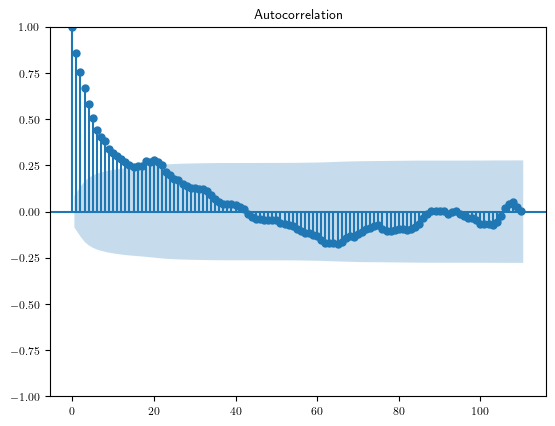

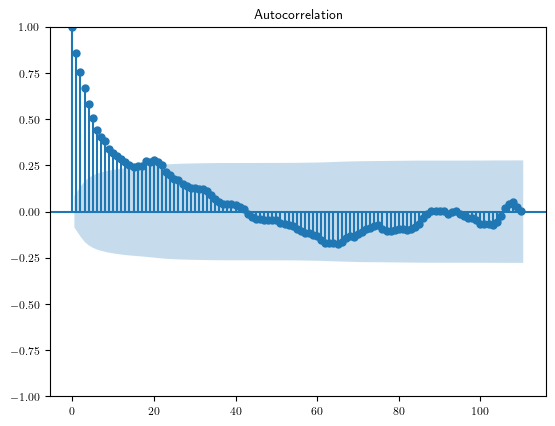

In [2586]:
plot_acf(rmse_400_res_vae, lags=110)

# Results

## BOOT

In [2772]:
wilcoxon_signed_rank_test_with_block_bootstrap(rmse_400_res_vae, rmse_400_res_h, block_size, num_bootstrap_samples)

2.4373705010689678e-70

In [2781]:
final_res

,rmse_10_heston,min_10_heston,mean_10_heston,median_10_heston,max_10_heston,rmse_100_heston,min_100_heston,mean_100_heston,median_100_heston,max_100_heston,...,rmse_350_vae,min_350_vae,mean_350_vae,median_350_vae,max_350_vae,rmse_400_vae,min_400_vae,mean_400_vae,median_400_vae,max_400_vae
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,0.069919,0.000244,0.054045,0.044642,0.289098,0.063651,0.000503,0.054356,0.051036,0.178287,...,0.021941,0.000045,0.018090,0.011015,0.089336,0.026962,0.000053,0.017464,0.010151,0.080969
2013-01-13,0.070641,0.000307,0.069649,0.056783,0.218312,0.063071,0.000574,0.052218,0.046051,0.207482,...,0.021229,0.000076,0.017586,0.011752,0.100078,0.024409,0.000101,0.017245,0.010554,0.083005
2013-01-20,0.069457,0.000342,0.066095,0.058902,0.220700,0.063875,0.000633,0.054808,0.048506,0.170918,...,0.016473,0.000057,0.013070,0.010622,0.075896,0.022322,0.000055,0.013662,0.012679,0.083190
2013-01-27,0.062936,-0.000106,0.059253,0.066669,0.257870,0.074548,0.000656,0.060519,0.053946,0.179610,...,0.020693,0.000068,0.019540,0.010676,0.082277,0.024753,0.000102,0.016021,0.011860,0.064742
2013-02-03,0.072639,0.000466,0.056667,0.054116,0.200822,0.060542,0.000971,0.060563,0.050060,0.177845,...,0.020953,0.000056,0.017170,0.011449,0.073322,0.021926,0.000060,0.017277,0.011662,0.076313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04,0.053938,0.000250,0.049339,0.039884,0.133622,0.056086,0.000157,0.043658,0.029936,0.232014,...,0.013050,0.000136,0.010189,0.006517,0.070268,0.011380,0.000058,0.010481,0.008277,0.064165
2022-12-11,0.068528,0.000178,0.054702,0.036146,0.199868,0.062919,0.000100,0.050913,0.030671,0.164430,...,0.014600,0.000031,0.010681,0.007735,0.087610,0.012924,0.000048,0.010261,0.010136,0.054080
2022-12-18,0.073403,0.000287,0.039625,0.046938,0.205527,0.058292,0.000225,0.038294,0.028194,0.172280,...,0.012721,0.000172,0.011221,0.008588,0.053645,0.018305,0.000029,0.011496,0.010094,0.056349


In [2782]:
def boot(meta):
    return wilcoxon_signed_rank_test_with_block_bootstrap(final_res[f'{meta["metric"]}_{meta["n"]}_heston'], final_res[f'{meta["metric"]}_{meta["n"]}_vae'], block_size, num_bootstrap_samples)

In [2785]:
p_values = meta_info[0:20].apply(boot, axis=1)

In [2793]:
p_values_with_meta = meta_info[0:20].copy()
p_values_with_meta[0] = p_values
p_values_with_meta['model'] = 'P'

In [2653]:
final_res = final_data.resample('1w').mean()

In [2654]:
ts = final_res.mean()

In [2691]:
meta_info = pd.DataFrame(np.array(list(ts.index.str.split('_'))), columns = ['metric', 'n', 'model'])

In [2692]:
ts_with_meta = pd.concat([pd.DataFrame(ts).reset_index(drop=True), meta_info], axis=1)

In [2796]:
ts_with_meta_and_p = pd.concat([ts_with_meta, p_values_with_meta])

In [2798]:
pvt = ts_with_meta_and_p.pivot_table(index=['n'], columns=['metric', 'model'],
                    values=[0], aggfunc='first')

In [2811]:
pvt_r = pvt.reindex(columns=['rmse', 'mean', 'median', 'min', 'max'], level=1)
pvt_r = pvt_r.reindex(columns=['heston', 'vae', 'P'], level=2)

In [2818]:
pvt_r.to_excel('tables/agg_results.xlsx')